<a href="https://colab.research.google.com/github/ryan-ng04/Facebook-Regression-Analyzer/blob/main/Facebook_Post_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.set_printoptions(sci_mode=False)  #Removes printing in scientific notation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [ ]:
data_pd = pd.read_csv('https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/facebook_data.csv');

In [ ]:
data_pd.head()

,Unnamed: 0,page_total_likes,type,category,post_month,post_weekday,post_hour,paid,total_interactions,total_reach
0,0,139441,0,2,12,4,3,0.0,100,2752
1,1,139441,1,2,12,3,10,0.0,164,10460
2,2,139441,0,3,12,3,3,0.0,80,2413
3,3,139441,0,2,12,2,10,1.0,1777,50128
4,4,139441,0,2,12,2,3,0.0,393,7244


1. Data Visualization & Analysis

<Axes: xlabel='post_month', ylabel='count'>

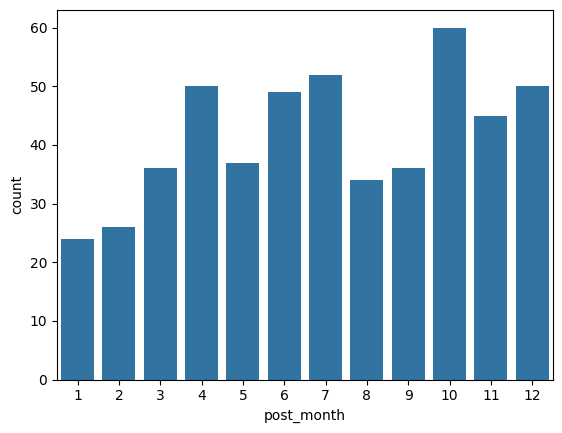

In [ ]:
plt.figure()
sns.countplot(x='post_month', data=data_pd)

<Axes: xlabel='post_weekday', ylabel='count'>

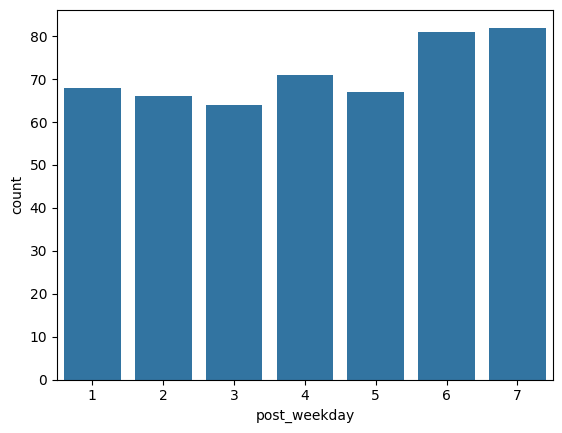

In [ ]:
sns.countplot(x='post_weekday', data=data_pd)

<Axes: xlabel='post_hour', ylabel='count'>

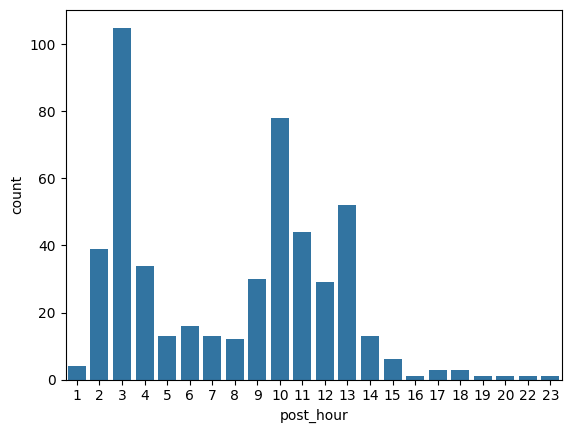

In [ ]:
sns.countplot(x='post_hour', data=data_pd)

<Axes: xlabel='total_interactions', ylabel='Count'>

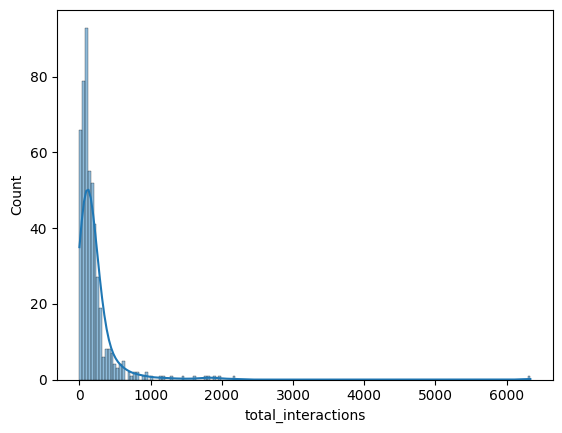

In [ ]:
sns.histplot(data_pd, x='total_interactions', kde =True)

<Axes: xlabel='total_reach', ylabel='Count'>

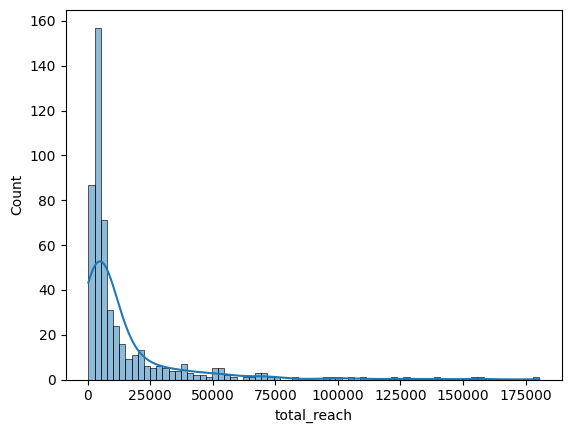

In [ ]:
sns.histplot(data_pd, x='total_reach', kde =True)

Text(0.5, 1.0, 'Pairwise Correlation of Features')

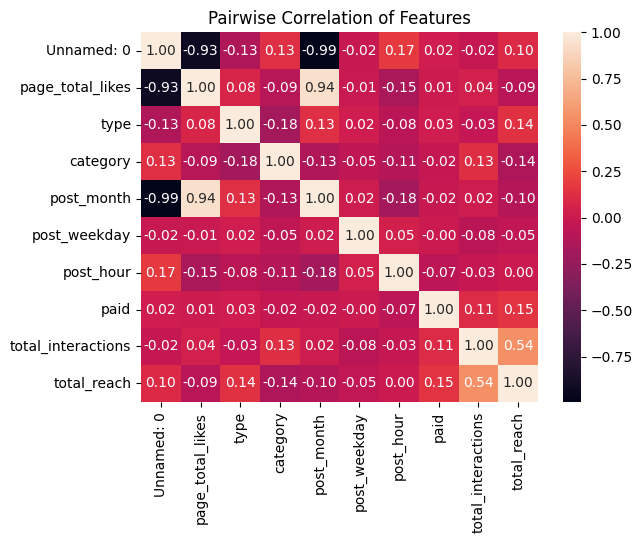

In [ ]:
correlation = data_pd.corr()
sns.heatmap(correlation, annot=True, fmt=".2f")
plt.title('Pairwise Correlation of Features')

Question 2

In [ ]:
#"Order of magnitude" normalization
X_pt = torch.tensor(data_pd['post_month'].values) /12
y_pt = torch.tensor(data_pd['total_reach'].values) / 175000

<Axes: xlabel='None', ylabel='None'>

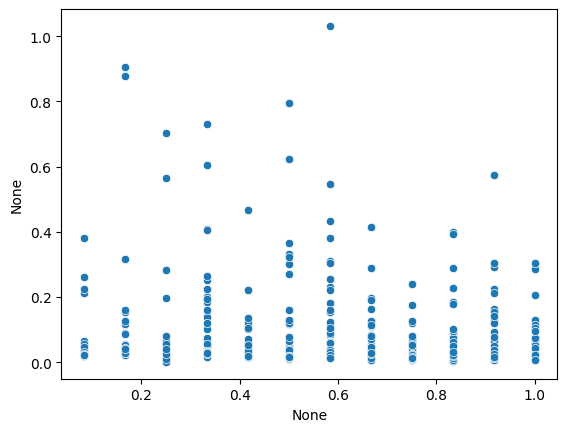

In [ ]:
sns.scatterplot(x=X_pt, y=y_pt)

In [ ]:
def linearModel(params, inputs):
  y_pred = params[0]*inputs + params[1]
  return y_pred

In [ ]:
def train_test_split(X,y,test_percent):
  numRows = y.size(0)                     #number or rows in the entire dataset
  splitPoint = int((1-test_percent)*numRows)  #the row index test_size% of the way through
  p = np.random.permutation(numRows)   #array for shuffling data
  X = X[p]
  y = y[p]

  #Training data array
  X_train = X[:splitPoint]  # training features , ieterates up to the splitpointe
  y_train = y[:splitPoint]  # training labels

  #Testing data array
  X_test = X[splitPoint:]  # testing features
  y_test = y[splitPoint:] # testing labels

  return X_train, X_test, y_train, y_test

In [ ]:
def gradDec(model, n_params, X_pt, y_pt, lr=0.05, n_epochs=2000, print_rate=200):

  params = 0.1*torch.rand(n_params).float() #Random inital paramaters
  params.requires_grad = True

  for epoch in range(n_epochs):
    y_pred = model(params, X_pt)
    loss_tenor = (y_pred - y_pt)**2
    loss = loss_tenor.mean()
    loss.backward()
    with torch.no_grad():
      params -= lr*params.grad
      params.grad.zero_()
    if epoch%print_rate==0:
      print("epoch:",epoch,"loss=",loss.item())

  pred = model(params, X_pt)
  pred_loss = (y_pred - y_pt)**2
  data_pd["difference_loss"] = pred_loss.detach().numpy().flatten()

  return params

In [ ]:
thresholds = [0.25, 0.5, 1.0]
folds = 5
def cross_validate_threshold(model, X, y, thresholds, folds, lr=0.01, n_epochs=1000):
  accuracy_dict = defaultdict(list)
  for fold in range(folds):
    x_train, x_test, y_train, y_test = train_test_split(X, y, 0.33)
    x_train_norm = (x_train - x_train.mean(dim=0)) / x_train.std(dim=0)
    y_train_norm = (y_train - y_train.mean(dim=0)) / y_train.std(dim=0)
    x_test_norm = (x_test - x_train.mean(dim=0)) / x_train.std(dim=0)
    y_test_norm = (y_test - y_train.mean(dim=0)) / y_train.std(dim=0)

    if X.ndim > 1:
      num_params = X.shape[1] + 1
    elif model == "nonLinearModel":
      num_params = 5
    else:
      num_params = 2
    params = torch.randn(num_params, requires_grad=True)

    for epoch in range(n_epochs):
      y_pred = model(params, x_train_norm)
      loss_tenor = (y_pred - y_train_norm)**2
      loss = loss_tenor.mean()
      loss.backward()
      with torch.no_grad():
        params -= lr*params.grad
        params.grad.zero_()

    y_pred_test = model(params, x_test_norm)

    for T in thresholds:
      std = torch.std(y_test_norm)
      difference = torch.abs(y_pred_test - y_test_norm)
      correct_threshold = difference <= (T *std)
      accuracy = correct_threshold.float().mean()
      accuracy_dict[T].append(accuracy)

  results = {}
  for T in thresholds:
    mean_acc = float(np.mean(accuracy_dict[T]))
    std_acc = float(np.std(accuracy_dict[T]))

    results[T] = {
        'mean': mean_acc,
        'std_dev': std_acc
    }

  return results

In [ ]:
cross_validate_threshold(linearModel, X_pt, y_pt, thresholds, folds)

{0.25: {'mean': 0.17575757205486298, 'std_dev': 0.02944232150912285},
 0.5: {'mean': 0.7187878489494324, 'std_dev': 0.15544481575489044},
 1.0: {'mean': 0.9090908765792847, 'std_dev': 0.012712850235402584}}

In [ ]:
params = gradDec(linearModel, 2, X_pt, y_pt)

epoch: 0 loss= 0.018332909792661667
epoch: 200 loss= 0.01682395301759243
epoch: 400 loss= 0.016709931194782257
epoch: 600 loss= 0.016697516664862633
epoch: 800 loss= 0.01669616438448429
epoch: 1000 loss= 0.016696017235517502
epoch: 1200 loss= 0.01669600047171116
epoch: 1400 loss= 0.01669599860906601
epoch: 1600 loss= 0.01669599860906601
epoch: 1800 loss= 0.01669599674642086


In [ ]:
data_pd.head()

,Unnamed: 0,page_total_likes,type,category,post_month,post_weekday,post_hour,paid,total_interactions,total_reach,difference_loss
0,0,139441,0,2,12,4,3,0.0,100,2752,1.888855e-03
1,1,139441,1,2,12,3,10,0.0,164,10460,3.419298e-07
2,2,139441,0,3,12,3,3,0.0,80,2413,2.060988e-03
3,3,139441,0,2,12,2,10,1.0,1777,50128,5.164666e-02
4,4,139441,0,2,12,2,3,0.0,393,7244,3.165694e-04


In [ ]:
#unnormalize
X_pt_raw = X_pt *12
y_pt_raw = y_pt * 175000

In [ ]:
cuts = pd.qcut(y_pt.detach().numpy().flatten(), q=5, labels=['low', 'low-med', 'medium', 'mid-high', 'high'])

In [ ]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='difference_loss'>

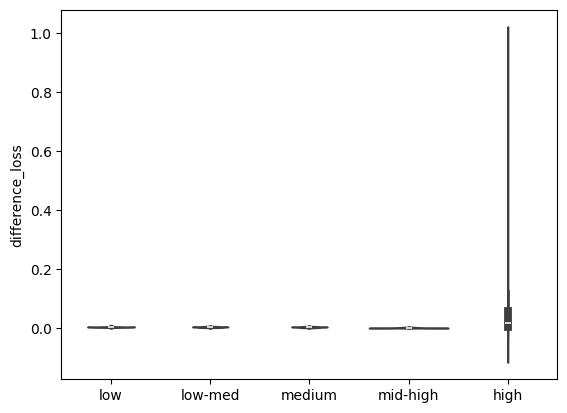

In [ ]:
sns.violinplot(x=cuts, y='difference_loss', data=data_pd)

In [ ]:
def threshold_acc(y_actual, y_pred, T):
  std = torch.std(y_actual)
  difference = torch.abs(y_pred - y_actual)
  correct_threshold = difference <= (T *std)
  accuracy = correct_threshold.float().mean()
  return accuracy.item()

In [ ]:
thresholds = [0.25, 0.5, 1.0]
y_pred = linearModel(params, X_pt)

In [ ]:
for T in thresholds:
  accuracies = threshold_acc(y_pt, y_pred ,T)
  print(f'{T} : {accuracies}')

0.25 : 0.15831662714481354
0.5 : 0.679358720779419
1.0 : 0.8997995853424072


In [ ]:
X_pt = torch.tensor(data_pd[['post_month', 'post_hour', 'type']].values).float()
y_pt = torch.tensor(data_pd['total_reach'].values).float()


In [ ]:
x_mean = X_pt.mean(dim=0) #dim = 0 tells us which dimension to take over
x_std = X_pt.std(dim=0)
x_mean

tensor([7.0501, 7.8477, 0.2204])

In [ ]:
x_norm = ((X_pt-x_mean)/x_std) /1.5
y_mean = y_pt.mean(dim=0)
y_norm = ((y_pt-y_mean)/y_pt.std(dim=0)) / 7

<Axes: xlabel='None', ylabel='None'>

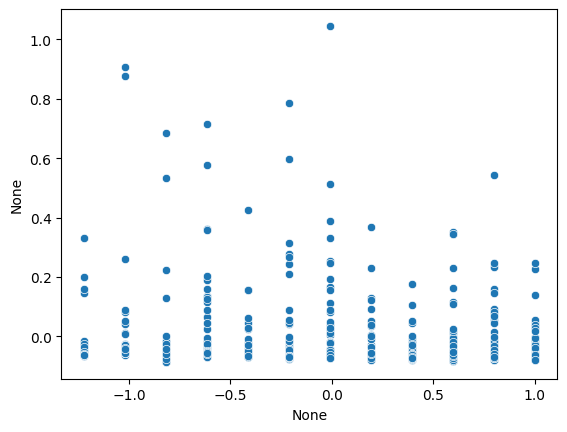

In [ ]:
sns.scatterplot(x=x_norm[:,0], y=y_norm)

In [ ]:
def multiLinearModel(params, inputs):
  y_pred = params[0]*inputs[:,0] + params[1]*inputs[:,1] + params[2]*inputs[:,2] + params[3]
  return y_pred

In [ ]:
params = gradDec(multiLinearModel, 4, x_norm, y_norm, 0.001)

epoch: 0 loss= 0.03079017996788025
epoch: 200 loss= 0.02586846612393856
epoch: 400 loss= 0.023344507440924644
epoch: 600 loss= 0.021978242322802544
epoch: 800 loss= 0.02119184099137783
epoch: 1000 loss= 0.020710313692688942
epoch: 1200 loss= 0.020398683845996857
epoch: 1400 loss= 0.020187832415103912
epoch: 1600 loss= 0.02004041150212288
epoch: 1800 loss= 0.01993497833609581


In [ ]:
#Unormalize the data
x_raw = x_norm * x_std + x_mean
y_raw = y_norm * y_pt.std(dim=0) + y_mean

<Axes: xlabel='None', ylabel='None'>

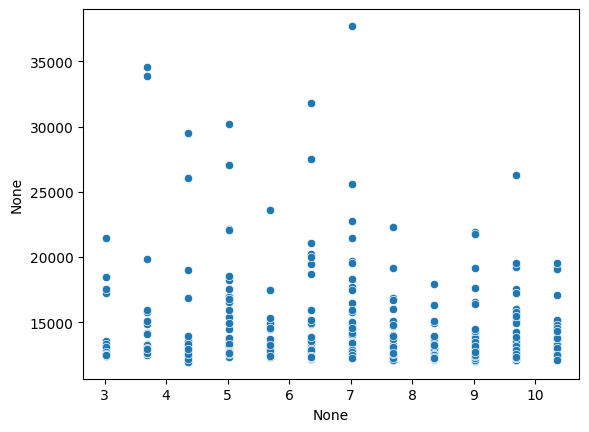

In [ ]:
sns.scatterplot(x=x_raw[:,0], y=y_raw)

In [ ]:
# gradDec(multiLinearModel, 4, x_raw, y_raw, 0.001)

In [ ]:
cuts = pd.qcut(y_norm.detach().numpy().flatten(), q=5, labels=['low', 'low-med', 'medium', 'mid-high', 'high'])

<Axes: ylabel='difference_loss'>

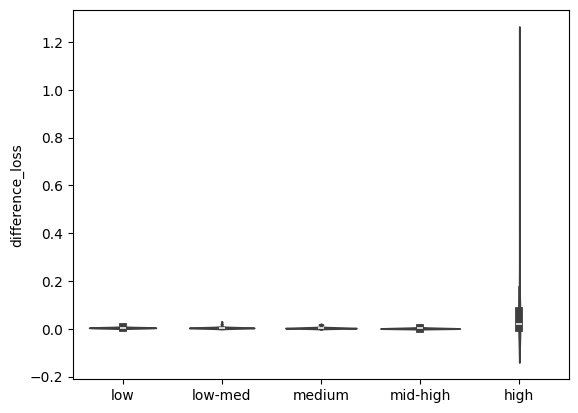

In [ ]:
plt.figure()
sns.violinplot(x=cuts, y='difference_loss', data=data_pd)

In [ ]:
cross_validate_threshold(multiLinearModel, x_norm, y_norm, thresholds, folds)

{0.25: {'mean': 0.162424236536026, 'std_dev': 0.04621981829404831},
 0.5: {'mean': 0.6036363840103149, 'std_dev': 0.1578831523656845},
 1.0: {'mean': 0.8812121152877808, 'std_dev': 0.02983887866139412}}

In [ ]:
def threshold_acc(y_actual, y_pred, T):
  std = torch.std(y_actual)
  difference = torch.abs(y_pred - y_actual)
  correct_threshold = difference <= (T *std)
  accuracy = correct_threshold.float().mean()
  return accuracy.item()

In [ ]:
thresholds = [0.25, 0.5, 1.0]
y_pred = multiLinearModel(params, x_norm)

In [ ]:
for T in thresholds:
  accuracies = threshold_acc(y_norm, y_pred ,T)
  print(f'{T} : {accuracies}')

0.25 : 0.146292582154274
0.5 : 0.7174348831176758
1.0 : 0.8977956175804138


In [ ]:
X_pt = torch.tensor(data_pd[['post_month', 'post_hour', 'type', 'paid']].values).float()
y_pt = torch.tensor(data_pd['total_reach'].values).float()

In [ ]:
def nonLinearModel(params, inputs):
  #y_pred = params[0]*inputs[:,0] + params[1]*(inputs[:,0]**2) + params[2]*(inputs[:,1]) + params[3]
  y_pred = params[0]*inputs[:,0] + params[1]*(inputs[:,0]*inputs[:,1]) + params[2]*(inputs[:,0]**2) + params[3]*inputs[:,0] + params[4]

  return y_pred

In [ ]:
params = gradDec(nonLinearModel, 5, x_norm, y_norm, 0.00095)

epoch: 0 loss= 0.0382983461022377
epoch: 200 loss= 0.029337001964449883
epoch: 400 loss= 0.02526737190783024
epoch: 600 loss= 0.023327676579356194
epoch: 800 loss= 0.022339509800076485
epoch: 1000 loss= 0.021790696308016777
epoch: 1200 loss= 0.021453844383358955
epoch: 1400 loss= 0.021225424483418465
epoch: 1600 loss= 0.02105684205889702
epoch: 1800 loss= 0.020924387499690056


In [ ]:
#Unormalize the data
x_raw = x_norm * x_std + x_mean
y_raw = y_norm * y_pt.std(dim=0) + y_mean

In [ ]:
#gradDec(nonLinearModel, 5, x_raw, y_raw, 0.001)

In [ ]:
cuts = pd.qcut(y_norm.detach().numpy().flatten(), q=5, labels=['low', 'low-med', 'medium', 'mid-high', 'high'])

<Axes: ylabel='difference_loss'>

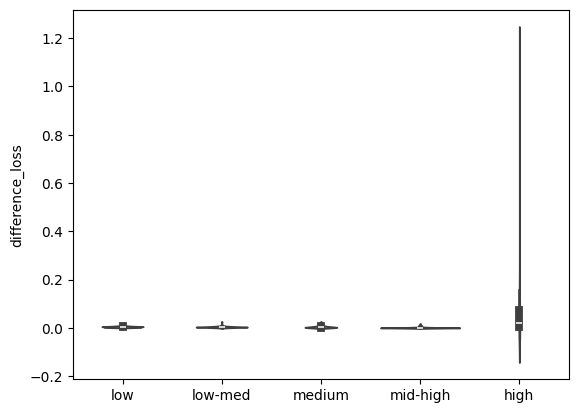

In [ ]:
plt.figure()
sns.violinplot(x=cuts, y='difference_loss', data=data_pd)

In [ ]:
thresholds = [0.25, 0.5, 1.0]
folds = 5
def cross_validate_threshold(model, X, y, thresholds, folds, lr=0.01, n_epochs=1000):
  accuracy_dict = defaultdict(list)
  for fold in range(folds):
    x_train, x_test, y_train, y_test = train_test_split(X, y, 0.33)
    x_train_norm = (x_train - x_train.mean(dim=0)) / x_train.std(dim=0)
    y_train_norm = (y_train - y_train.mean(dim=0)) / y_train.std(dim=0)
    x_test_norm = (x_test - x_train.mean(dim=0)) / x_train.std(dim=0)
    y_test_norm = (y_test - y_train.mean(dim=0)) / y_train.std(dim=0)

    if model == nonLinearModel:
      num_params = 5
    else:
      num_params = 2
    params = torch.randn(num_params, requires_grad=True)

    for epoch in range(n_epochs):
      y_pred = model(params, x_train_norm)
      loss_tenor = (y_pred - y_train_norm)**2
      loss = loss_tenor.mean()
      loss.backward()
      with torch.no_grad():
        params -= lr*params.grad
        params.grad.zero_()

    y_pred_test = model(params, x_test_norm)

    for T in thresholds:
      std = torch.std(y_test_norm)
      difference = torch.abs(y_pred_test - y_test_norm)
      correct_threshold = difference <= (T *std)
      accuracy = correct_threshold.float().mean()
      accuracy_dict[T].append(accuracy)

  results = {}
  for T in thresholds:
    mean_acc = float(np.mean(accuracy_dict[T]))
    std_acc = float(np.std(accuracy_dict[T]))

    results[T] = {
        'mean_accuracy': mean_acc,
        'std_dev': std_acc
    }

  return results

In [ ]:
def threshold_acc(y_actual, y_pred, T):
  std = torch.std(y_actual)
  difference = torch.abs(y_pred - y_actual)
  correct_threshold = difference <= (T *std)
  accuracy = correct_threshold.float().mean()
  return accuracy.item()

In [ ]:
thresholds = [0.25, 0.5, 1.0]
y_pred = nonLinearModel(params, x_norm)

In [ ]:
for T in thresholds:
  accuracies = threshold_acc(y_norm, y_pred ,T)
  print(f'{T} : {accuracies}')

0.25 : 0.19438877701759338
0.5 : 0.6312625408172607
1.0 : 0.8937875628471375


In [ ]:
cross_validate_threshold(nonLinearModel, x_norm, y_norm, thresholds, folds)

{0.25: {'mean_accuracy': 0.23393937945365906, 'std_dev': 0.04295768216252327},
 0.5: {'mean_accuracy': 0.7781819105148315, 'std_dev': 0.09140070527791977},
 1.0: {'mean_accuracy': 0.9006060361862183, 'std_dev': 0.010567043907940388}}